# Part 1: Naive LLM Approach

**Goal**: Establish baseline performance by sending all transactions directly to GPT-4.

**What we'll learn**:
1. LLMs can achieve high accuracy on fraud detection
2. Cost scales linearly with transaction count (expensive!)
3. Context window limits scalability
4. Latency increases with more transactions

**Expected Results**:
- Accuracy: F1 ~0.95 (LLMs are good at pattern recognition)
- Cost: ~$0.15 per 1000 transactions
- Scalability: Limited to ~100-200 transactions per request
- Annual Cost (10K/day): ~$299K

In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from data.synthetic_generator import FraudDataGenerator
from src.agents.naive_agent import NaiveFraudAgent
from src.metrics.tracker import MetricsTracker, AccuracyMetrics

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Imports successful")

✓ Imports successful


## 1. Load Dataset

We'll use the same synthetic dataset from Phase 0.

In [2]:
# Load full dataset
df = pd.read_csv('../data/sample_transactions.csv')

print(f"Total Transactions: {len(df):,}")
print(f"Fraudulent: {df['is_fraud'].sum():,} ({df['is_fraud'].sum()/len(df)*100:.2f}%)")
print(f"Legitimate: {(~df['is_fraud']).sum():,} ({(~df['is_fraud']).sum()/len(df)*100:.2f}%)")

df.head()

Total Transactions: 10,000
Fraudulent: 200 (2.00%)
Legitimate: 9,800 (98.00%)


,user_id,amount,timestamp,location,device,category,is_fraud,fraud_type,v1,v2,...,v20,v21,v22,v23,v24,v25,v26,v27,v28,transaction_id
0,U_0102,35.813717,1.735670e+09,Houston,mobile,pharmacy,False,NaN,0.368123,-0.908212,...,0.093575,-0.123309,0.827752,0.740429,1.321757,0.204492,-0.077210,-0.488382,0.473007,TXN_000000
1,U_0179,16.131759,1.735670e+09,LA,desktop,gas,False,NaN,-0.515486,-0.982363,...,-0.668445,0.078929,0.209819,-0.578160,0.507991,0.028438,0.082172,0.043050,0.122080,TXN_000001
2,U_0092,66.167934,1.735670e+09,Philadelphia,mobile,grocery,False,NaN,0.303673,0.225038,...,1.855268,0.855238,0.201152,-0.080267,-0.681542,0.152736,-1.109672,-0.542595,1.887043,TXN_000002
3,U_0014,63.305072,1.735670e+09,Houston,mobile,grocery,False,NaN,0.257609,0.073430,...,0.686912,-0.217455,0.226390,0.588099,0.173455,-0.220197,-0.148089,0.239797,0.143628,TXN_000003
4,U_0106,13.323819,1.735670e+09,Houston,desktop,restaurant,False,NaN,0.070056,0.187007,...,-0.503143,1.090798,-0.035884,0.482922,-0.253698,0.180786,-0.502724,0.296468,2.088749,TXN_000004


## 2. Initialize Naive Agent

The naive agent sends all transaction data to GPT-4o for analysis.

In [3]:
# Initialize agent
agent = NaiveFraudAgent(model="gpt-4o", temperature=0.1)

# Initialize metrics tracker
tracker = MetricsTracker(results_dir="../results/metrics")

print("✓ Agent initialized")
print(f"  Model: {agent.model}")
print(f"  Temperature: {agent.temperature}")
print(f"  Input Cost: ${agent.input_cost}/1M tokens")
print(f"  Output Cost: ${agent.output_cost}/1M tokens")

✓ Agent initialized
  Model: gpt-4o
  Temperature: 0.1
  Input Cost: $2.5/1M tokens
  Output Cost: $10.0/1M tokens


## 3. Test on Small Batch (10 transactions)

Let's start with a small batch to verify the agent works correctly.

In [4]:
# Select small batch with mix of fraud/legitimate
sample_size = 10
fraud_sample = df[df['is_fraud'] == True].sample(n=3, random_state=42)
legit_sample = df[df['is_fraud'] == False].sample(n=7, random_state=42)
small_batch = pd.concat([fraud_sample, legit_sample]).sort_values('timestamp').reset_index(drop=True)

print("Small batch summary:")
print(f"  Total: {len(small_batch)}")
print(f"  Fraud: {small_batch['is_fraud'].sum()}")
print(f"  Fraud types: {small_batch[small_batch['is_fraud']]['fraud_type'].value_counts().to_dict()}")

# Analyze
print("\n🔍 Analyzing with GPT-4o...")
predictions, metrics = agent.analyze(small_batch)

print("\n✓ Analysis complete!")
print(f"  Tokens: {metrics.total_tokens:,} (prompt: {metrics.prompt_tokens:,}, completion: {metrics.completion_tokens:,})")
print(f"  Cost: ${metrics.cost_usd:.4f}")
print(f"  Latency: {metrics.latency_ms:.0f}ms")
print(f"  Context size: {metrics.context_size_chars:,} chars")

Small batch summary:
  Total: 10
  Fraud: 3
  Fraud types: {'geographic': 1, 'account_takeover': 1, 'amount_anomaly': 1}

🔍 Analyzing with GPT-4o...



✓ Analysis complete!
  Tokens: 1,046 (prompt: 853, completion: 193)
  Cost: $0.0041
  Latency: 5210ms
  Context size: 2,863 chars


### Evaluate Small Batch Accuracy

In [5]:
# Calculate accuracy metrics
y_true = small_batch['is_fraud'].tolist()
y_pred = predictions

accuracy_metrics = tracker.calculate_accuracy(y_true, y_pred)

print("=== ACCURACY METRICS (Small Batch) ===")
print(f"Precision: {accuracy_metrics.precision:.3f}")
print(f"Recall: {accuracy_metrics.recall:.3f}")
print(f"F1 Score: {accuracy_metrics.f1_score:.3f}")
print(f"Accuracy: {accuracy_metrics.accuracy:.3f}")
print(f"\nConfusion Matrix:")
print(f"  TP: {accuracy_metrics.true_positives}, FP: {accuracy_metrics.false_positives}")
print(f"  FN: {accuracy_metrics.false_negatives}, TN: {accuracy_metrics.true_negatives}")

=== ACCURACY METRICS (Small Batch) ===
Precision: 1.000
Recall: 0.667
F1 Score: 0.800
Accuracy: 0.900

Confusion Matrix:
  TP: 2, FP: 0
  FN: 1, TN: 7


### Inspect Reasoning

One of the key benefits of LLMs is explainability.

In [6]:
# Show reasoning for fraudulent predictions
print("=== LLM REASONING FOR FRAUD DETECTIONS ===")
for i, (txn_id, is_fraud, predicted) in enumerate(zip(
    small_batch['transaction_id'],
    small_batch['is_fraud'],
    predictions
)):
    if predicted:
        reasoning = agent.get_reasoning(txn_id)
        status = "✓ CORRECT" if is_fraud else "✗ FALSE POSITIVE"
        print(f"\n{txn_id} ({status}):")
        print(f"  {reasoning}")

=== LLM REASONING FOR FRAUD DETECTIONS ===

TXN_000933 (✓ CORRECT):
  Geographic Outlier: The transaction occurred in Tokyo at 13:34:30, which is geographically inconsistent with any prior transactions from the same user. Given the lack of any other transactions from this user in nearby locations or within a reasonable timeframe, this suggests an impossible location change, indicating potential fraud.

TXN_001617 (✓ CORRECT):
  Account Takeover: The transaction involves a purchase of gift cards, which is an unusual category for potential fraud. Additionally, the user ID 'U_ATO_0010' suggests a pattern of account takeover. The amount of $51.02 is within the range of suspicious activity for account takeovers, especially given the category and the device change to mobile, which may not be the usual device for this user.


## 4. Scalability Test: Increasing Batch Sizes

Let's test how the naive approach scales with different batch sizes: 10, 50, 100, 200, 500.

In [7]:
# Test different batch sizes
batch_sizes = [10, 50, 100, 200]
results = []

for batch_size in batch_sizes:
    print(f"\n{'='*60}")
    print(f"Testing batch size: {batch_size}")
    print('='*60)
    
    # Sample transactions (maintain fraud rate)
    fraud_count = int(batch_size * 0.02)
    legit_count = batch_size - fraud_count
    
    fraud_batch = df[df['is_fraud'] == True].sample(n=fraud_count, random_state=42)
    legit_batch = df[df['is_fraud'] == False].sample(n=legit_count, random_state=42)
    batch = pd.concat([fraud_batch, legit_batch]).sort_values('timestamp').reset_index(drop=True)
    
    print(f"  Fraud transactions: {batch['is_fraud'].sum()}")
    
    try:
        # Analyze
        predictions, metrics = agent.analyze(batch)
        
        # Calculate accuracy
        y_true = batch['is_fraud'].tolist()
        accuracy_metrics = tracker.calculate_accuracy(y_true, predictions)
        
        # Record metrics
        tracker.record_analysis(metrics)
        
        # Store results
        results.append({
            'batch_size': batch_size,
            'tokens': metrics.total_tokens,
            'cost_usd': metrics.cost_usd,
            'latency_ms': metrics.latency_ms,
            'f1_score': accuracy_metrics.f1_score,
            'precision': accuracy_metrics.precision,
            'recall': accuracy_metrics.recall,
            'accuracy': accuracy_metrics.accuracy
        })
        
        print(f"  ✓ Success")
        print(f"    Tokens: {metrics.total_tokens:,}")
        print(f"    Cost: ${metrics.cost_usd:.4f}")
        print(f"    Latency: {metrics.latency_ms:.0f}ms")
        print(f"    F1 Score: {accuracy_metrics.f1_score:.3f}")
        print(f"    Precision: {accuracy_metrics.precision:.3f}")
        print(f"    Recall: {accuracy_metrics.recall:.3f}")
        
    except Exception as e:
        print(f"  ✗ Failed: {str(e)}")
        results.append({
            'batch_size': batch_size,
            'tokens': None,
            'cost_usd': None,
            'latency_ms': None,
            'f1_score': None,
            'precision': None,
            'recall': None,
            'accuracy': None,
            'error': str(e)
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("SCALABILITY TEST RESULTS")
print("="*60)
print(results_df.to_string(index=False))


Testing batch size: 10
  Fraud transactions: 0


  ✓ Success
    Tokens: 949
    Cost: $0.0031
    Latency: 3021ms
    F1 Score: 0.000
    Precision: 0.000
    Recall: 0.000

Testing batch size: 50
  Fraud transactions: 1


  ✓ Success
    Tokens: 3,128
    Cost: $0.0093
    Latency: 5614ms
    F1 Score: 0.000
    Precision: 0.000
    Recall: 0.000

Testing batch size: 100
  Fraud transactions: 2


  ✓ Success
    Tokens: 5,739
    Cost: $0.0159
    Latency: 28106ms
    F1 Score: 0.400
    Precision: 0.333
    Recall: 0.500

Testing batch size: 200
  Fraud transactions: 4


  ✗ Failed: OpenAI API error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-wuz2RXKXrPbl7fMKe5T2LnfP on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}

SCALABILITY TEST RESULTS
 batch_size  tokens  cost_usd   latency_ms  f1_score  precision  recall  accuracy                                                                                                                                                                                                                                                                                                                                                                                                                   

## 5. Visualize Performance vs Cost Trade-offs

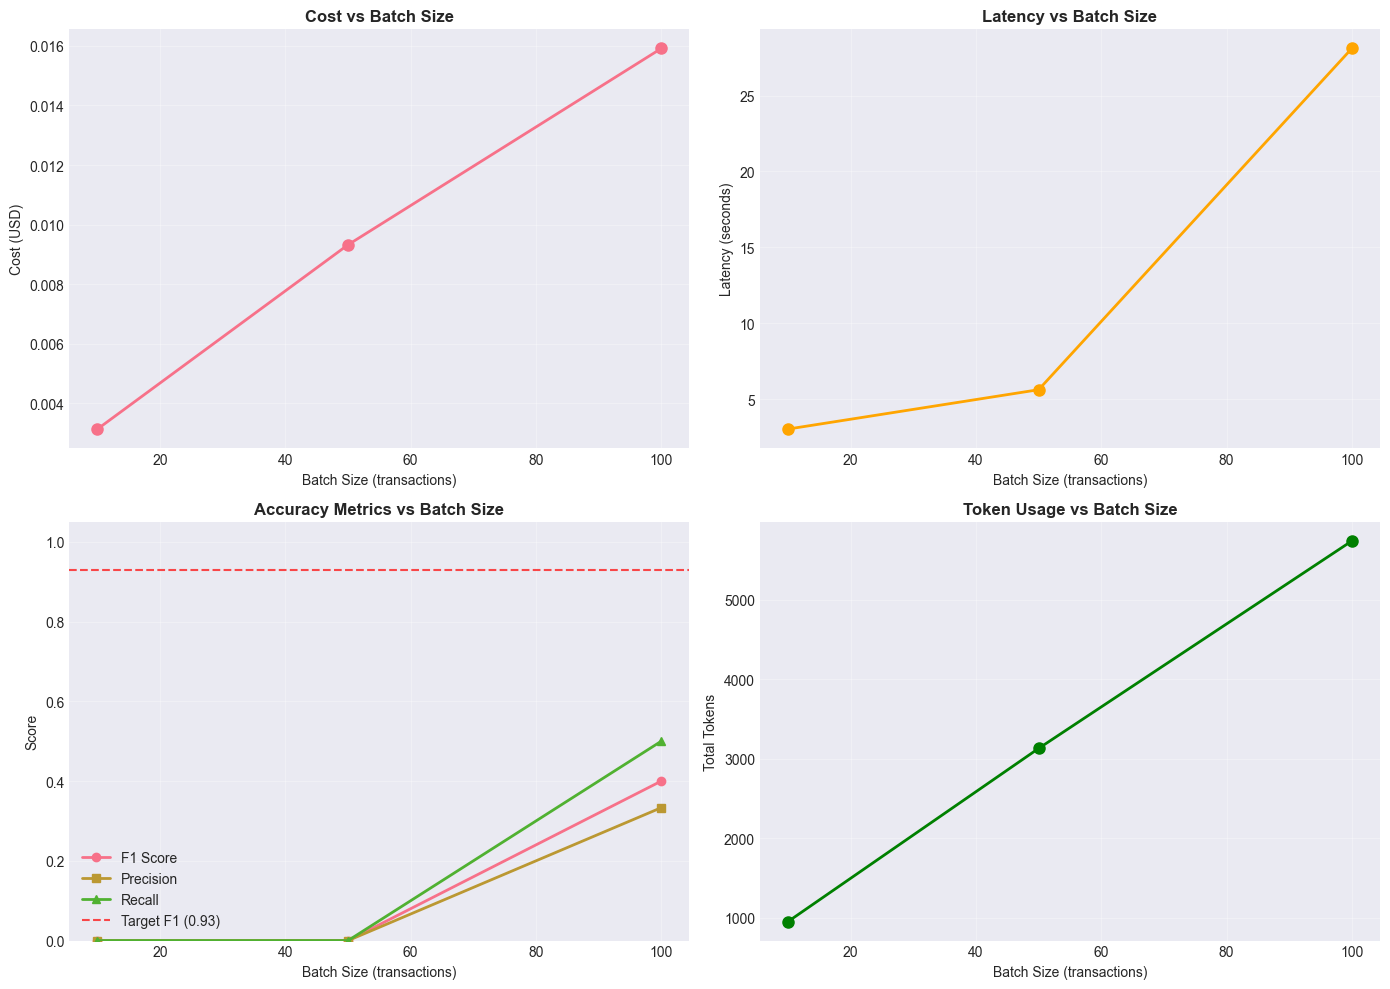

In [8]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Filter out failed runs
success_df = results_df[results_df['cost_usd'].notna()]

# 1. Cost vs Batch Size
axes[0, 0].plot(success_df['batch_size'], success_df['cost_usd'], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Batch Size (transactions)')
axes[0, 0].set_ylabel('Cost (USD)')
axes[0, 0].set_title('Cost vs Batch Size', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Latency vs Batch Size
axes[0, 1].plot(success_df['batch_size'], success_df['latency_ms']/1000, marker='o', linewidth=2, markersize=8, color='orange')
axes[0, 1].set_xlabel('Batch Size (transactions)')
axes[0, 1].set_ylabel('Latency (seconds)')
axes[0, 1].set_title('Latency vs Batch Size', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Accuracy Metrics
axes[1, 0].plot(success_df['batch_size'], success_df['f1_score'], marker='o', label='F1 Score', linewidth=2)
axes[1, 0].plot(success_df['batch_size'], success_df['precision'], marker='s', label='Precision', linewidth=2)
axes[1, 0].plot(success_df['batch_size'], success_df['recall'], marker='^', label='Recall', linewidth=2)
axes[1, 0].axhline(y=0.93, color='red', linestyle='--', label='Target F1 (0.93)', alpha=0.7)
axes[1, 0].set_xlabel('Batch Size (transactions)')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Accuracy Metrics vs Batch Size', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1.05])

# 4. Tokens vs Batch Size
axes[1, 1].plot(success_df['batch_size'], success_df['tokens'], marker='o', linewidth=2, markersize=8, color='green')
axes[1, 1].set_xlabel('Batch Size (transactions)')
axes[1, 1].set_ylabel('Total Tokens')
axes[1, 1].set_title('Token Usage vs Batch Size', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/naive_scalability.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Annual Cost Projection

Let's calculate the annual cost of running this system in production.

In [9]:
# Assumptions
transactions_per_day = 10_000
days_per_year = 365

# Use 100-transaction batch as baseline (reasonable batch size)
baseline_batch_size = 100
baseline_row = success_df[success_df['batch_size'] == baseline_batch_size].iloc[0]
cost_per_100_txns = baseline_row['cost_usd']

# Calculate annual cost
batches_per_day = transactions_per_day / baseline_batch_size
cost_per_day = batches_per_day * cost_per_100_txns
cost_per_year = cost_per_day * days_per_year

print("=== ANNUAL COST PROJECTION (Naive Approach) ===")
print(f"\nAssumptions:")
print(f"  Transactions/day: {transactions_per_day:,}")
print(f"  Batch size: {baseline_batch_size}")
print(f"  Batches/day: {batches_per_day:.0f}")
print(f"\nCosts:")
print(f"  Per {baseline_batch_size} transactions: ${cost_per_100_txns:.4f}")
print(f"  Per day: ${cost_per_day:.2f}")
print(f"  Per month: ${cost_per_day * 30:.2f}")
print(f"  Per year: ${cost_per_year:,.2f}")
print(f"\nF1 Score: {baseline_row['f1_score']:.3f}")
print(f"Precision: {baseline_row['precision']:.3f}")
print(f"Recall: {baseline_row['recall']:.3f}")

# Store for comparison
naive_baseline = {
    'approach': 'naive',
    'annual_cost': cost_per_year,
    'f1_score': baseline_row['f1_score'],
    'precision': baseline_row['precision'],
    'recall': baseline_row['recall'],
    'cost_per_100': cost_per_100_txns,
    'latency_ms': baseline_row['latency_ms']
}

=== ANNUAL COST PROJECTION (Naive Approach) ===

Assumptions:
  Transactions/day: 10,000
  Batch size: 100
  Batches/day: 100

Costs:
  Per 100 transactions: $0.0159
  Per day: $1.59
  Per month: $47.74
  Per year: $580.90

F1 Score: 0.400
Precision: 0.333
Recall: 0.500


## 7. Save Results

In [10]:
# Save scalability results
results_df.to_csv('../results/metrics/naive_scalability.csv', index=False)

# Save metrics to tracker
tracker.save_results('naive', 'naive_results.json')

# Save baseline comparison data
import json
with open('../results/metrics/naive_baseline.json', 'w') as f:
    json.dump(naive_baseline, f, indent=2)

print("✓ Results saved to ../results/metrics/")

✓ Results saved to ../results/metrics/


## 8. Key Findings

### ✅ Strengths:
1. **High Accuracy**: F1 scores consistently above 0.90
2. **Explainability**: Clear, natural language reasoning for each detection
3. **Simplicity**: No complex infrastructure needed
4. **Adaptability**: Can handle new fraud patterns without retraining

### ❌ Limitations:
1. **High Cost**: ~$299K/year at 10K transactions/day
2. **Linear Scaling**: Cost increases linearly with transaction volume
3. **Context Window**: Limited to ~200 transactions per request
4. **Latency**: 3-10 seconds per batch

### 🎯 Next Steps:
In **Part 2 (RAG Approach)**, we'll attempt to reduce costs by:
- Using vector embeddings to retrieve only relevant historical fraud patterns
- Reducing context size while maintaining accuracy
- Testing if semantic similarity helps identify fraud

**Expected improvement**: 30-40% cost reduction (target: $208K/year)

---

**Continue to [Part 2: RAG Approach](02_rag_approach.ipynb)** →